# Big Data and Machine Learning Project
## Prepared by Said Magomedov

## Data Mining and Analysis

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import requests, re, time, warnings
from tqdm import tqdm
from scipy.stats import norm
from bs4 import BeautifulSoup
from io import StringIO
from statsmodels.tsa.filters import hp_filter
from pprint import pprint

warnings.filterwarnings('ignore')

In [ ]:
# DO NOT WORRY IF YOU GET AN ERROR WHEN TRYING TO RUN IT!
# I HAVE ONLY SUCCEEDED WITH A SPECIFIC VPN ON THE AMERICAN SERVER AFTER MULTIPLE ATTEMPTS
# I AM NOT A SPECIALIST IN WEBSCRAPING SO I DO NOT KNOW WHAT ACTUALLY CAUSES AN ERROR
# BECAUSE THE PARSING ALGORITHM ALWAYS CRUSHES ON DIFFERENT ITERATIONS SAYING THAT "NONE OBJECT HAS NO ATTRIBUTE ..."
# I GUESS IT HAPPENS DUE TO SOME CONNECTION INSTABILITIES OR SOME OTHER ISSUES AS WEBSITE'S ANTI SCRAPING POLICY

# set the analyzing period and base urls
years = range(1991, 2024)
url1 = 'https://www.basketball-reference.com/awards/awards_{}.html'
url2 = 'https://www.basketball-reference.com{}'
tables = []

for year in years:
    url = url1.format(year)
    html = requests.get(url1).text
    soup = BeautifulSoup(html, 'html.parser')
    soup.find('tr', class_='over_header').decompose() # get rid of the unnecessary headings
    table = soup.find_all(id='mvp')[0] # extract the MVP table by its specific id
    table_df = pd.read_html(StringIO(str(table)))[0] # convert to data frame
    
    # get links for players' personal webpages
    tbody = soup.find('tbody')
    tbody_rows = tbody.find_all('tr')
    links = []
    for row in tbody_rows:
        cell = row.find('td', class_='left').find('a')
        links.append(cell['href'])
    
    # extract their playing position
    positions = []
    
    for link in tqdm(links):
        url_player = url2.format(link)
        html_player = requests.get(url_player).text
        soup_player = BeautifulSoup(html_player, 'html.parser')
        p = soup_player.find('strong', string=re.compile('Position:', re.IGNORECASE)).find_parent()
        p_str = ''.join(char for char in p.text if char.isalpha())
        pos = p_str.replace('Position', '').replace('Shoots', ' ').split(' ')[0]
        
        if 'Guard' in pos and 'Forward' in pos:
            if pos.index('Forward') < pos.index('Guard'):
                positions.append('Forward')
            else:
                positions.append('Guard')
        elif 'Forward' in pos and 'Center' in pos:
            if pos.index('Forward') < pos.index('Center'):
                positions.append('Forward')
            else:
                positions.append('Center')
        elif 'Guard' in pos:
            positions.append('Guard')
        elif 'Forward' in pos:
            positions.append('Forward')
        elif 'Center' in pos:
            positions.append('Center')

    table_df['Position'] = positions
    table_df['Year'] = year
    tables.append(table_df)
    
    time.sleep(1)
    
nba_final1 = pd.concat(tables)
nba_final1.to_csv('nba_final1.csv', index=False)

---
---

In [4]:
nba = pd.read_csv('nba_data.csv')
display(nba)
print(f'Number of unique players is {len(nba["Player"].unique())}')

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Position,Year
0,1,Michael Jordan,27,CHI,77.0,891.0,960,0.928,82,37.0,...,5.5,2.7,1.0,0.539,0.312,0.851,20.3,0.321,Guard,1991
1,2,Magic Johnson,31,LAL,10.0,497.0,960,0.518,79,37.1,...,12.5,1.3,0.2,0.477,0.320,0.906,15.4,0.251,Guard,1991
2,3,David Robinson,25,SAS,6.0,476.0,960,0.496,82,37.7,...,2.5,1.5,3.9,0.552,0.143,0.762,17.0,0.264,Center,1991
3,4,Charles Barkley,27,PHI,2.0,222.0,960,0.231,67,37.3,...,4.2,1.6,0.5,0.570,0.284,0.722,13.4,0.258,Forward,1991
4,5,Karl Malone,27,UTA,0.0,142.0,960,0.148,82,40.3,...,3.3,1.1,1.0,0.527,0.286,0.770,15.5,0.225,Forward,1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,9,Stephen Curry,34,GSW,0.0,5.0,1000,0.005,56,34.7,...,6.3,0.9,0.4,0.493,0.427,0.915,7.8,0.192,Guard,2023
495,10,Jimmy Butler,33,MIA,0.0,3.0,1000,0.003,64,33.4,...,5.3,1.8,0.3,0.539,0.350,0.850,12.3,0.277,Forward,2023
496,11,De'Aaron Fox,25,SAC,0.0,2.0,1000,0.002,73,33.4,...,6.1,1.1,0.3,0.512,0.324,0.780,7.4,0.146,Guard,2023
497,12T,Jalen Brunson,26,NYK,0.0,1.0,1000,0.001,68,35.0,...,6.2,0.9,0.2,0.491,0.416,0.829,8.7,0.175,Guard,2023


Number of unique players is 144


In [5]:
# add a categorical variable responsible for the player's position 
nba['POS'] = 0  
nba.loc[nba['Position'] == 'Forward', 'POS'] = 1
nba.loc[nba['Position'] == 'Center', 'POS'] = 2

In [6]:
# remove unnecessary columns and rearrange the remaining ones 
nba = nba.drop(['First', 'Pts Won', 'Pts Max', 'MP', 'WS/48'], axis=1)
nba.columns = nba.columns.str.rstrip('%')
col = nba.pop('Position')
nba.insert(3, col.name, col)
col = nba.pop('Year')
nba.insert(len(nba.columns), col.name, col)
print(nba.columns[nba.isnull().any()])

Index(['3P'], dtype='object')


In [7]:
players_no3P = nba[nba['3P'].isnull()].index.tolist()
nba = nba.fillna(0)
pprint(set(nba.iloc[players_no3P, 1]))

{'Anthony Mason',
 'Carlos Boozer',
 'Dikembe Mutombo',
 'Elton Brand',
 'P.J. Brown',
 'Rudy Gobert',
 "Shaquille O'Neal"}


In [8]:
# let's show MVPs of all time
mvps = nba.loc[nba['Rank'] == '1', :]
display(mvps)

,Rank,Player,Age,Position,Tm,Share,G,PTS,TRB,AST,STL,BLK,FG,3P,FT,WS,POS,Year
0,1,Michael Jordan,27,Guard,CHI,0.928,82,31.5,6.0,5.5,2.7,1.0,0.539,0.312,0.851,20.3,0,1991
20,1,Michael Jordan,28,Guard,CHI,0.938,80,30.1,6.4,6.1,2.3,0.9,0.519,0.270,0.832,17.7,0,1992
37,1,Charles Barkley,29,Forward,PHO,0.852,76,25.6,12.2,5.1,1.6,1.0,0.520,0.305,0.765,14.4,1,1993
51,1,Hakeem Olajuwon,31,Center,HOU,0.880,80,27.3,11.9,3.6,1.6,3.7,0.528,0.421,0.716,14.3,2,1994
68,1,David Robinson,29,Center,SAS,0.858,81,27.6,10.8,2.9,1.7,3.2,0.530,0.300,0.774,17.5,2,1995
83,1,Michael Jordan,32,Guard,CHI,0.986,82,30.4,6.6,4.3,2.2,0.5,0.495,0.427,0.834,20.4,0,1996
100,1,Karl Malone,33,Forward,UTA,0.857,82,27.4,9.9,4.5,1.4,0.6,0.550,0.000,0.755,16.7,1,1997
120,1,Michael Jordan,34,Guard,CHI,0.934,82,28.7,5.8,3.5,1.7,0.5,0.465,0.238,0.784,15.8,0,1998
139,1,Karl Malone,35,Forward,UTA,0.701,49,23.8,9.4,4.1,1.3,0.6,0.493,0.000,0.788,9.6,1,1999
160,1,Shaquille O'Neal,27,Center,LAL,0.998,79,29.7,13.6,3.8,0.5,3.0,0.574,0.000,0.524,18.6,2,2000


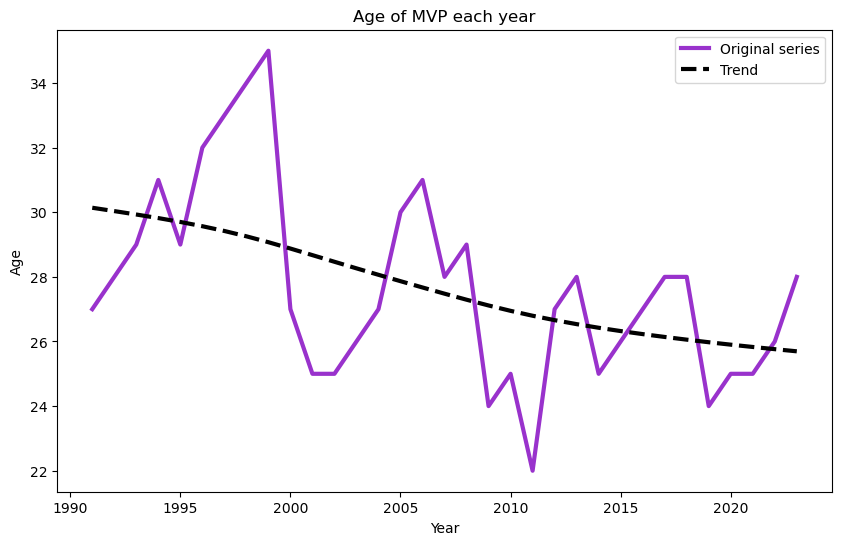

In [9]:
# apply Hodrick-Prescott filter to variable Age in the dataframe for MVPs
series = mvps['Age']
series.index = pd.to_datetime(mvps['Year'], format='%Y')
cycle, trend = hp_filter.hpfilter(series)

# plot both lines
plt.figure(figsize=(10, 6))
plt.plot(mvps['Year'], mvps['Age'], color='darkorchid', linewidth=3, label='Original series')
plt.plot(mvps['Year'], trend, '--', color='black', linewidth=3, label='Trend')
plt.legend()
plt.title('Age of MVP each year')
plt.xlabel('Year')
plt.ylabel('Age')
plt.show()

# plt.savefig('mvps_age.jpg')

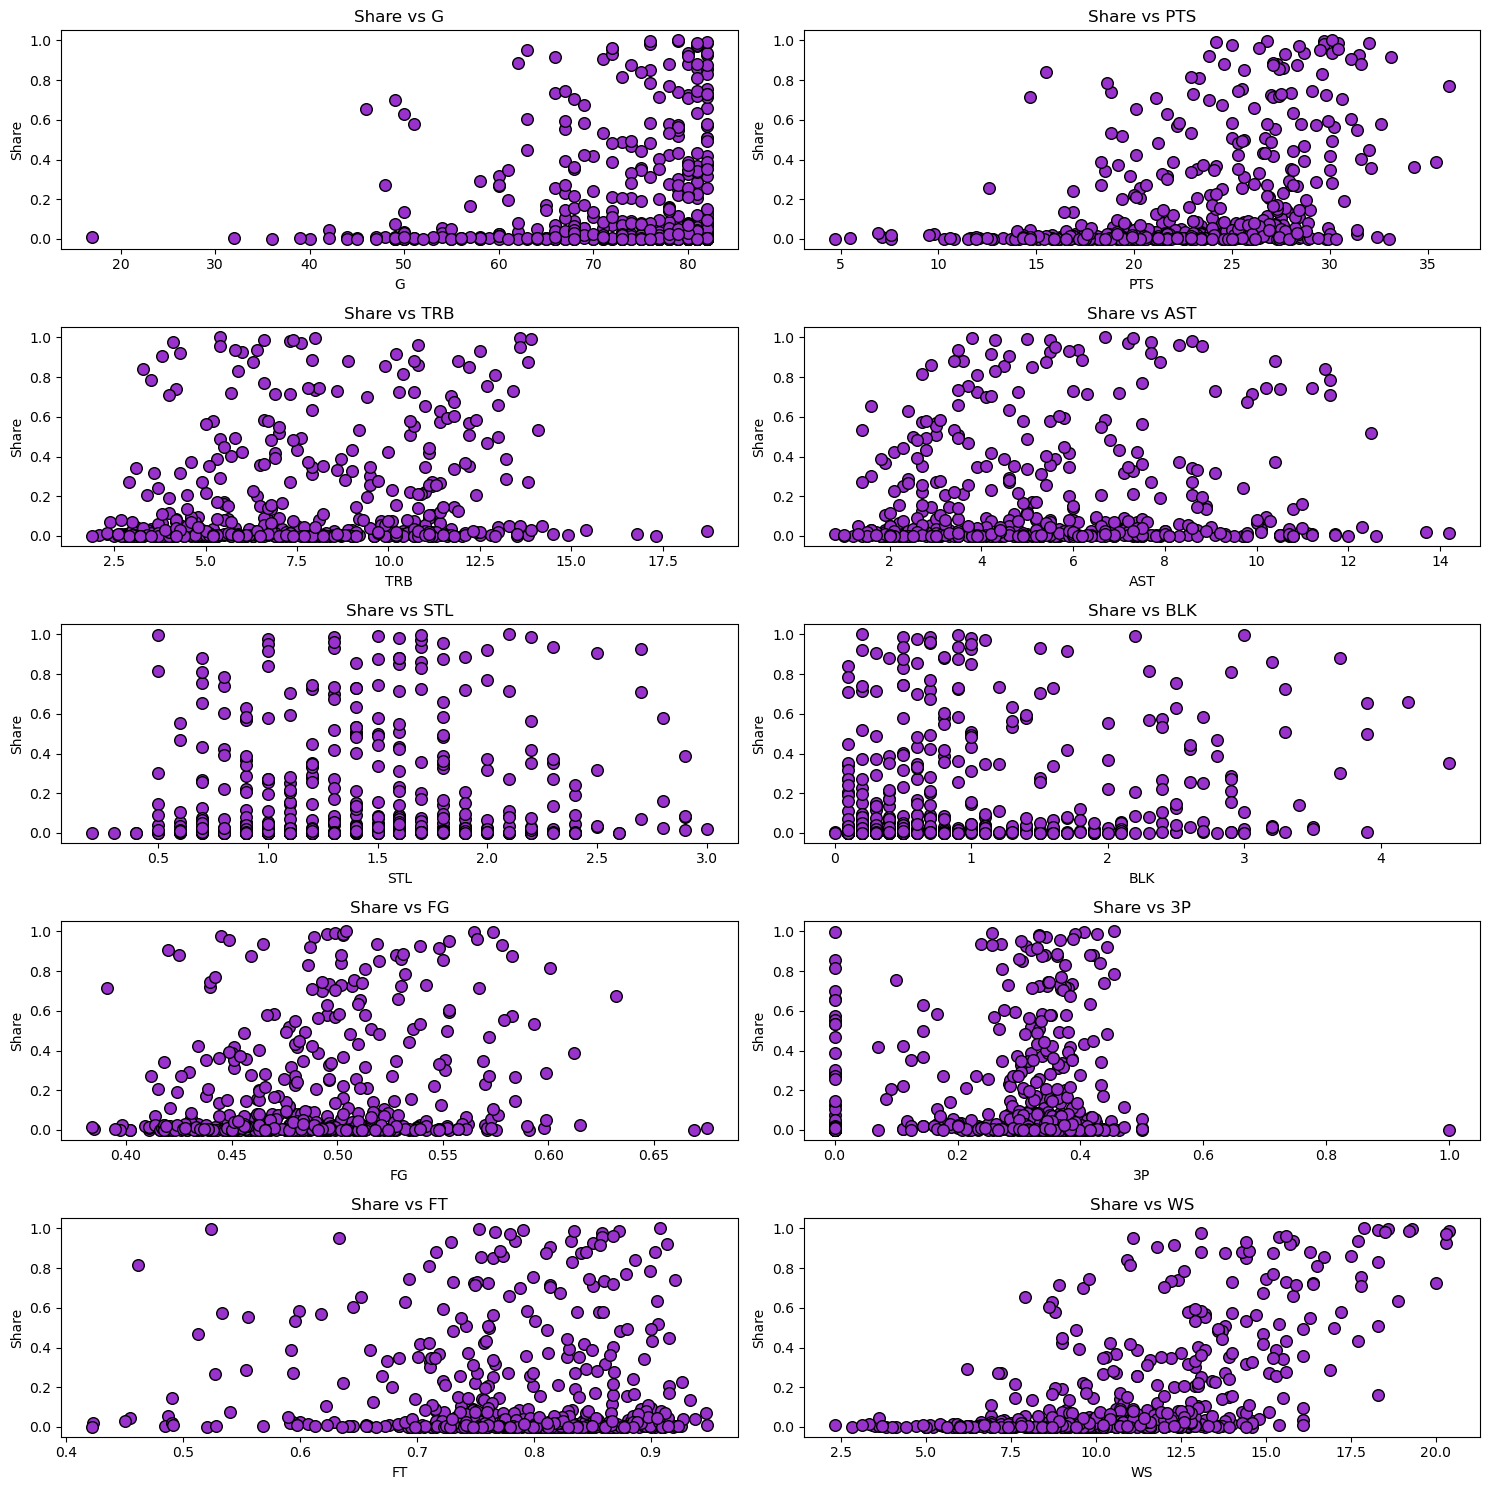

In [10]:
Y = nba['Share']
X = nba.iloc[:,6:-1]
plt.figure(figsize=(15, 15))
for i, var in enumerate(X.iloc[:,:-1].columns):
    plt.subplot(5, 2, i+1)
    plt.scatter(X[var], Y, color='darkorchid', edgecolor='black', s=70)
    plt.title(f'{Y.name} vs {var}')
    plt.xlabel(var)
    plt.ylabel(Y.name)

plt.tight_layout()
plt.show()

# plt.savefig('scatters.jpg')

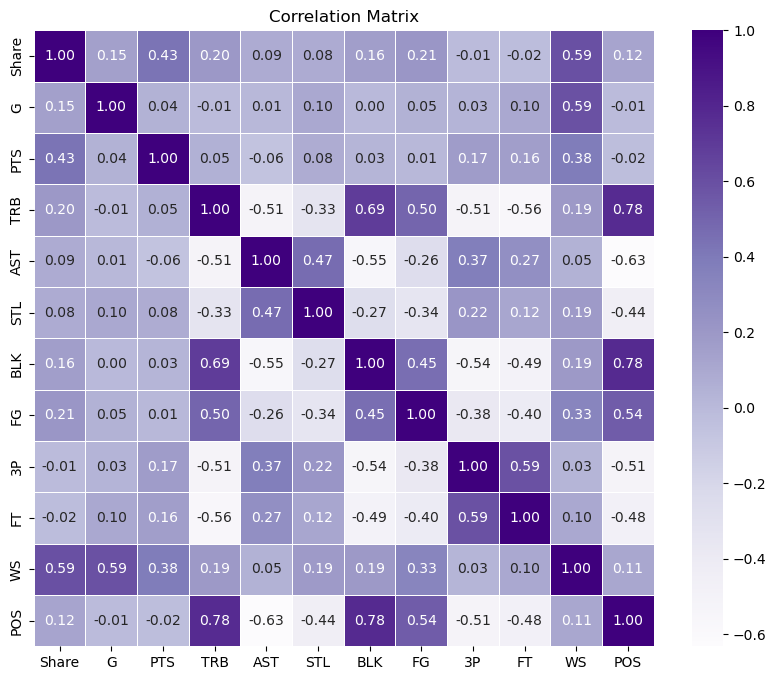

In [11]:
corr_matrix = nba.iloc[:,5:-1].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='Purples', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# plt.savefig('corr_matrix.jpg')

In [12]:
nba.describe().iloc[1:, :-1].round(2)

,Age,Share,G,PTS,TRB,AST,STL,BLK,FG,3P,FT,WS,POS
mean,27.72,0.17,72.65,22.55,7.51,5.27,1.39,0.96,0.49,0.30,0.78,10.82,0.76
std,3.89,0.27,10.49,5.20,3.27,2.69,0.53,0.89,0.05,0.13,0.09,3.33,0.76
min,19.00,0.00,17.00,4.70,1.90,0.80,0.20,0.00,0.38,0.00,0.42,2.30,0.00
25%,25.00,0.00,68.00,19.30,4.80,3.10,1.00,0.30,0.46,0.27,0.74,8.70,0.00
50%,27.00,0.02,77.00,22.90,7.00,4.90,1.40,0.60,0.48,0.33,0.80,10.70,1.00
75%,30.00,0.24,81.00,26.60,10.25,7.00,1.70,1.30,0.51,0.38,0.85,12.90,1.00
max,38.00,1.00,82.00,36.10,18.70,14.20,3.00,4.50,0.68,1.00,0.95,20.40,2.00


In [13]:
# nba_desc_stats = nba.describe().iloc[1:, 0:-1].round(2).to_latex(index=True)

# with open("table_ds.tex", "w") as file:
#     file.write(nba_desc_stats)

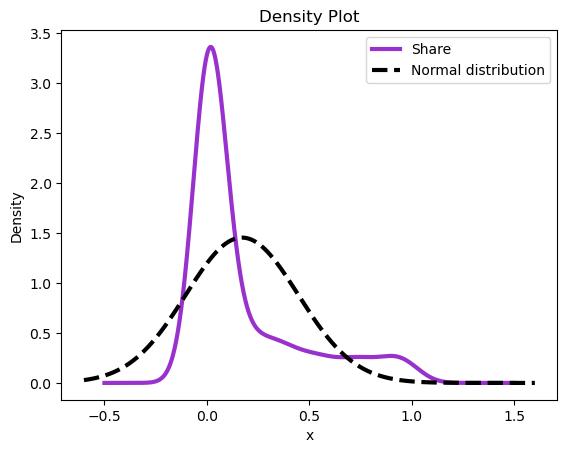

In [14]:
Y.plot.kde(label='Share', color='darkorchid', linewidth=3)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
y = norm.pdf(x, Y.mean(), nba['Share'].std())  
plt.plot(x, y, "--", label='Normal distribution', color='black', linewidth=3)
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Density Plot')
plt.legend()
plt.show()

# plt.savefig("densities.jpg")

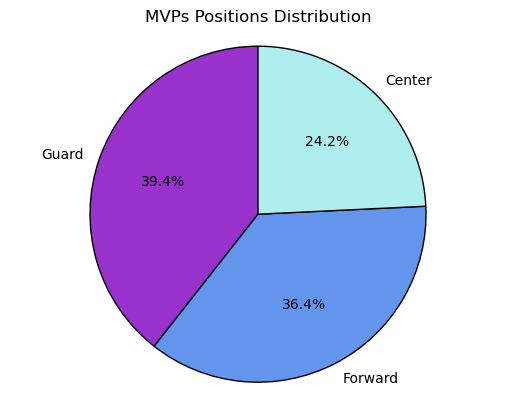

In [15]:
pos_counts = mvps['Position'].value_counts()
plt.pie(pos_counts, labels=pos_counts.index, autopct='%1.1f%%', startangle=90, 
        wedgeprops=dict(edgecolor='black', linewidth=1),
        colors=['darkorchid', 'cornflowerblue', 'paleturquoise'])
plt.axis('equal') 
plt.title('MVPs Positions Distribution')
plt.show()

# plt.savefig("pos_piechart.jpg")

### Optional and not very informative and relevant statistics

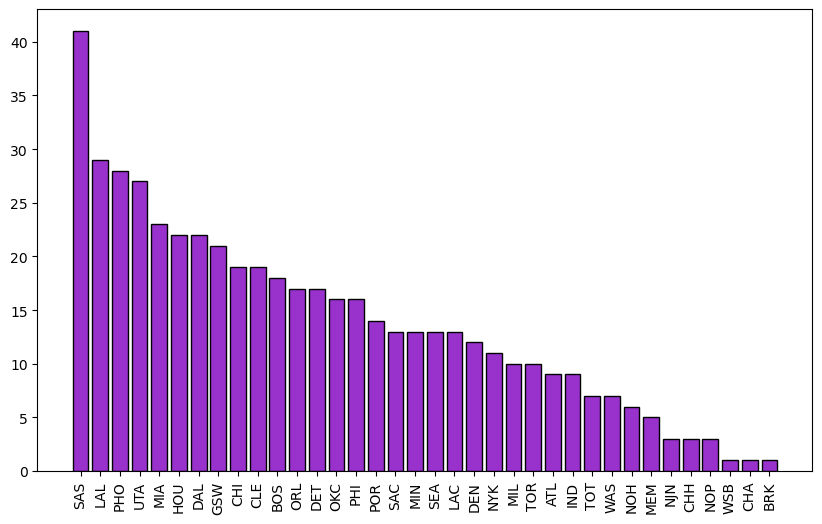

In [16]:
plt.figure(figsize=(10, 6))
bars = plt.bar(nba['Tm'].value_counts().index, nba['Tm'].value_counts(), 
               color='darkorchid', edgecolor='black', width=0.8)
plt.xticks(rotation='vertical', ha='center')  
plt.show()

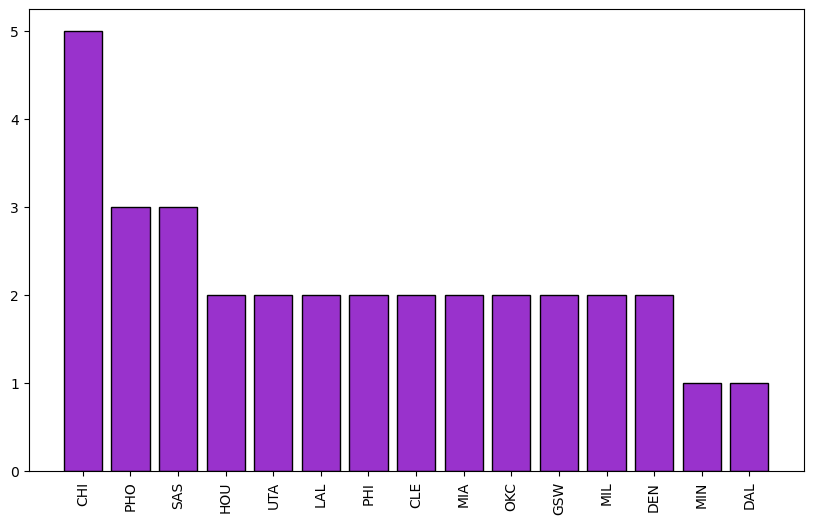

In [17]:
plt.figure(figsize=(10, 6))
bars = plt.bar(mvps['Tm'].value_counts().index, mvps['Tm'].value_counts(), 
               color='darkorchid', edgecolor='black', width=0.8)
plt.xticks(rotation='vertical', ha='center')  
plt.show()

---
---

## Building ML models. Full Sample

In [18]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [19]:
# scale data
X_cols = X.columns
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=X_cols)

# last season has 13 MVP nominees
X_train = X.iloc[:-13,:]
Y_train = Y.iloc[:-13]
X_test = X.iloc[-13:,:]
Y_test = Y.iloc[-13:]

In [20]:
n_estimators = [50, 100, 200, 400]
learning_rate = [0.001, 0.01, 0.1, 0.2]
max_depth = [3, 5, 7, 9]

params_xgb = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth
}

params_ada = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'base_estimator__max_depth': max_depth
}

params_cat = {
    'iterations': n_estimators,
    'learning_rate': learning_rate,
    'depth': max_depth
}

params_rf = {
    'n_estimators': n_estimators,
    'max_depth': max_depth
}

In [21]:
# create a function for running 4 different algorithms: XGBoost, AdaBoost, CatBoost and Random Forest
# and printing some appropriate results
# notice that number of cross validation folds is set to 3

def my_algo(X_train, Y_train, X_test, Y_test, algo_name):
    
    if algo_name == 'XGBoost':
        model = XGBRegressor()
        params = params_xgb
    elif algo_name == 'AdaBoost':
        model = AdaBoostRegressor(estimator=DecisionTreeRegressor(), random_state=42)
        params = params_ada
    elif algo_name == 'CatBoost':
        model = CatBoostRegressor(verbose=False)
        params = params_cat
    elif algo_name == 'Random Forest':
        model = RandomForestRegressor(random_state=42)
        params = params_rf
    
    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error', cv=3)
    grid_result = grid_search.fit(X_train, Y_train)

    best_model = grid_result.best_estimator_
    best_params = grid_result.best_params_
    Y_pred_is = best_model.predict(X_train)
    Y_pred_oos = best_model.predict(X_test)
    rmse_is = mean_squared_error(Y_train, Y_pred_is, squared=False)
    rmse_oos = mean_squared_error(Y_test, Y_pred_oos, squared=False)
    ranking = list(np.argsort(Y_pred_oos)[::-1]+1)
    
    cv_scores = cross_val_score(best_model, X, Y, cv=3, scoring='neg_mean_squared_error')
    cv_rmse = np.mean((-cv_scores)**0.5)
    
    return {'IS prediction': Y_pred_is, 
            'OOS prediction': Y_pred_oos,
            'IS RMSE': rmse_is,
            'OOS RMSE': rmse_oos,
            'Ranking': ranking, 
            'Best params': best_params, 
            'CV RMSE': cv_rmse, 
            'Feature Importances': dict(zip(X.columns, best_model.feature_importances_))}


def print_algo(my_algo):
    
    for key, value in my_algo['Best params'].items():
        print(f'Best {key}: {value}')
    print(f'OOS RMSE: {my_algo["OOS RMSE"].round(3)}')
    print(f'CV RMSE: {my_algo["CV RMSE"].round(3)}')
    print(f'Predicted ranking: {my_algo["Ranking"]}')

### XGBoost

In [19]:
xgb = my_algo(X_train, Y_train, X_test, Y_test, 'XGBoost')
print_algo(xgb)

Best learning_rate: 0.01
Best max_depth: 3
Best n_estimators: 200
OOS RMSE: 0.216
CV RMSE: 0.214
Predicted ranking: [1, 2, 5, 3, 8, 6, 7, 4, 10, 9, 12, 13, 11]


### AdaBoost

In [20]:
ada = my_algo(X_train, Y_train, X_test, Y_test, 'AdaBoost')
print_algo(ada)

Best base_estimator__max_depth: 5
Best learning_rate: 0.2
Best n_estimators: 50
OOS RMSE: 0.182
CV RMSE: 0.213
Predicted ranking: [2, 1, 5, 3, 8, 4, 6, 7, 10, 12, 9, 13, 11]


### CatBoost

In [21]:
cat = my_algo(X_train, Y_train, X_test, Y_test, 'CatBoost')
print_algo(cat)

Best depth: 3
Best iterations: 50
Best learning_rate: 0.1
OOS RMSE: 0.227
CV RMSE: 0.211
Predicted ranking: [2, 1, 8, 5, 3, 7, 4, 6, 10, 9, 13, 12, 11]


### Random Forest

In [22]:
rf = my_algo(X_train, Y_train, X_test, Y_test, 'Random Forest')
print_algo(rf)

Best max_depth: 3
Best n_estimators: 100
OOS RMSE: 0.227
CV RMSE: 0.213
Predicted ranking: [1, 2, 5, 3, 7, 8, 4, 10, 9, 6, 13, 11, 12]


### Elastic Net

In [22]:
en = ElasticNetCV().fit(X_train, Y_train)
en_is = en.predict(X_train)
en_oos = en.predict(X_test)
rmse_en_is = mean_squared_error(Y_train, en_is, squared=False)
rmse_en_oos = mean_squared_error(Y_test, en_oos, squared=False)
ranking_en = list(np.argsort(en_oos)[::-1]+1)
cv_scores_en = cross_val_score(en, X, Y, cv=3, scoring='neg_mean_squared_error')
cv_rmse_en = np.mean((-cv_scores_en)**0.5)
en_coefs = dict(zip(X_train.columns, en.coef_.round(3)))
print(f'Prediction RMSE: {rmse_en_oos.round(3)}', 
      f'CV RMSE: {cv_rmse_en.round(3)}',
      f'R-squared: {r2_score(Y_test, en_oos).round(3)}',
      f'Predicted ranking: {ranking_en}', 
      f'Coefficient Estimates:', sep='\n')
display(en_coefs)

Prediction RMSE: 0.232
CV RMSE: 0.211
R-squared: 0.425
Predicted ranking: [2, 1, 8, 3, 5, 10, 4, 7, 9, 6, 12, 13, 11]
Coefficient Estimates:


{'G': -0.378,
 'PTS': 0.357,
 'TRB': 0.044,
 'AST': 0.245,
 'STL': -0.107,
 'BLK': 0.0,
 'FG': -0.131,
 '3P': -0.044,
 'FT': -0.137,
 'WS': 0.977,
 'POS': 0.056}

### Stacking

In [24]:
X_stack_is = pd.DataFrame({'XGBoost': xgb['IS prediction'],
                           'AdaBoost': ada['IS prediction'],
                           'CatBoost': cat['IS prediction'], 
                           'Random Forest': rf['IS prediction'], 
                           'Elastic Net': en_is})

X_stack_oos = pd.DataFrame({'XGBoost': xgb['OOS prediction'], 
                            'AdaBoost': ada['OOS prediction'],
                            'CatBoost': cat['OOS prediction'], 
                            'Random Forest': rf['OOS prediction'], 
                            'Elastic Net': en_oos})

meta = LinearRegression().fit(X_stack_is, Y_train)
meta_pred = meta.predict(X_stack_oos)
rmse_meta = mean_squared_error(Y_test, meta_pred, squared=False)
ranking_meta = list(np.argsort(meta_pred)[::-1]+1)
print(f'Prediction RMSE: {rmse_meta.round(3)}', 
      f'Predicted ranking: {ranking_meta}', sep='\n')

Prediction RMSE: 0.168
Predicted ranking: [2, 1, 5, 3, 8, 4, 6, 10, 7, 12, 13, 9, 11]


In [25]:
compar_table = {'Original': Y_test,
                'XGBoost': xgb['OOS prediction'],
                'AdaBoost': ada['OOS prediction'],
                'CatBoost': cat['OOS prediction'],
                'Random Forest': rf['OOS prediction'],
                'Elastic Net': en_oos,
                'Ensemble Stacking': meta_pred}

compar_df = pd.DataFrame(compar_table)
display(compar_df.round(3))

,Original,XGBoost,AdaBoost,CatBoost,Random Forest,Elastic Net,Ensemble Stacking
486,0.915,0.457,0.589,0.389,0.422,0.400,0.661
487,0.674,0.408,0.650,0.450,0.391,0.489,0.784
488,0.606,0.277,0.210,0.233,0.207,0.262,0.175
489,0.280,0.143,0.177,0.182,0.153,0.231,0.155
490,0.046,0.318,0.279,0.250,0.294,0.256,0.236
491,0.030,0.147,0.151,0.159,0.111,0.088,0.148
492,0.027,0.144,0.136,0.192,0.188,0.221,0.073
493,0.010,0.208,0.198,0.253,0.186,0.326,0.171
494,0.005,0.128,0.085,0.136,0.122,0.154,0.025
495,0.003,0.139,0.131,0.149,0.123,0.251,0.090


In [58]:
# compar_df_tex = compar_df.to_latex(index=False)
# with open('compar_df1.tex', 'w') as file:
#     file.write(compar_df_tex)

---

## Truncated Sample

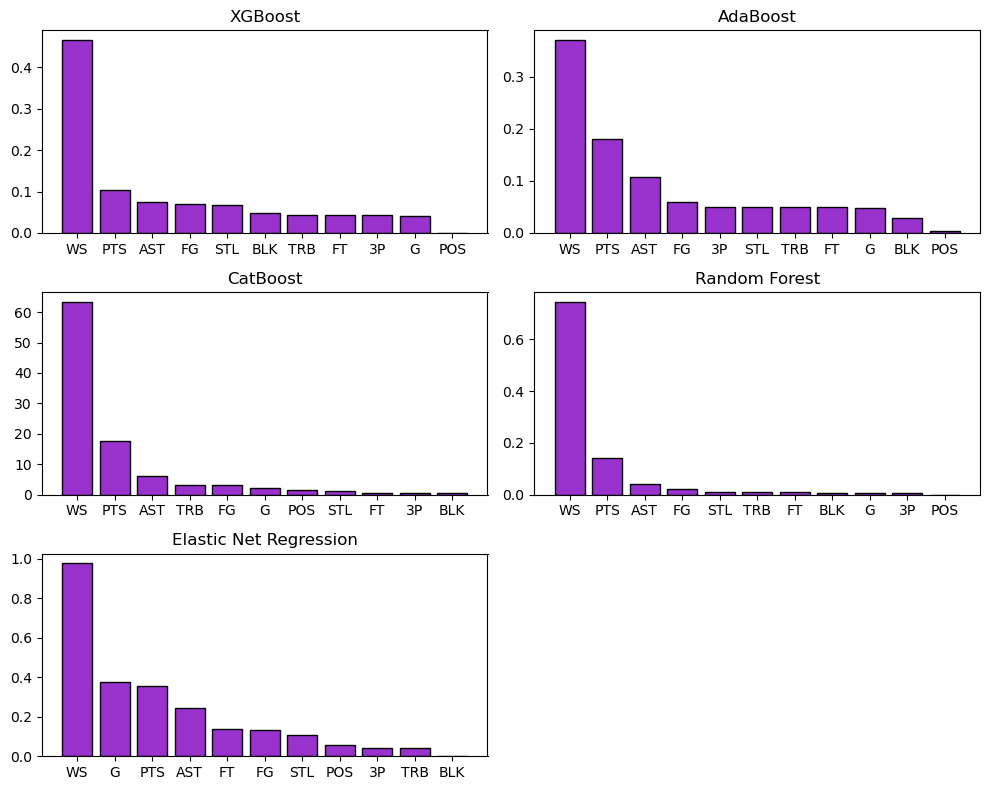

In [27]:
algos = {'XGBoost': xgb, 
         'AdaBoost': ada, 
         'CatBoost': cat, 
         'Random Forest': rf}

plt.figure(figsize=(10,8))
for i, (algo_name, algo) in enumerate(algos.items()):
    
    sorted_algo = {k: v for k, v in sorted(algo['Feature Importances'].items(), key=lambda item: item[1])[::-1]}
    
    plt.subplot(3,2,i+1)
    plt.bar(sorted_algo.keys(), sorted_algo.values(), color='darkorchid', edgecolor='black')
    plt.title(algo_name)
    
sorted_en = {k: abs(v) for k, v in sorted(en_coefs.items(), key=lambda item: abs(item[1]))[::-1]}
plt.subplot(3,2,i+2)
plt.bar(sorted_en.keys(), sorted_en.values(), color='darkorchid', edgecolor='black')
plt.title('Elastic Net Regression')

plt.tight_layout()
plt.savefig('feature_imps.jpg')
plt.show()

In [28]:
X_train_trunc = X_train.copy().drop(['BLK', 'TRB', '3P', 'POS'], axis=1)
X_test_trunc = X_test.copy().drop(['BLK', 'TRB', '3P', 'POS'], axis=1)

### XGBoost truncated

In [29]:
xgb_trunc = my_algo(X_train_trunc, Y_train, X_test_trunc, Y_test, 'XGBoost')
print_algo(xgb_trunc)

Best learning_rate: 0.01
Best max_depth: 3
Best n_estimators: 200
OOS RMSE: 0.216
CV RMSE: 0.214
Predicted ranking: [1, 2, 5, 3, 8, 7, 6, 10, 4, 9, 12, 13, 11]


### AdaBoost truncated

In [30]:
ada_trunc = my_algo(X_train_trunc, Y_train, X_test_trunc, Y_test, 'AdaBoost')
print_algo(ada_trunc)

Best base_estimator__max_depth: 3
Best learning_rate: 0.01
Best n_estimators: 400
OOS RMSE: 0.225
CV RMSE: 0.212
Predicted ranking: [1, 2, 5, 7, 3, 10, 8, 4, 9, 6, 12, 11, 13]


### CatBoost truncated

In [31]:
cat_trunc = my_algo(X_train_trunc, Y_train, X_test_trunc, Y_test, 'CatBoost')
print_algo(cat_trunc)

Best depth: 3
Best iterations: 400
Best learning_rate: 0.01
OOS RMSE: 0.23
CV RMSE: 0.209
Predicted ranking: [2, 1, 5, 3, 8, 4, 7, 9, 10, 6, 13, 11, 12]


### Random Forest truncated

In [32]:
rf_trunc = my_algo(X_train_trunc, Y_train, X_test_trunc, Y_test, 'Random Forest')
print_algo(rf_trunc)

Best max_depth: 9
Best n_estimators: 50
OOS RMSE: 0.176
CV RMSE: 0.217
Predicted ranking: [1, 2, 3, 5, 8, 7, 10, 9, 4, 6, 13, 12, 11]


### Elastic Net truncated



In [33]:
en_trunc = ElasticNetCV().fit(X_train_trunc, Y_train)
en_trunc_is = en_trunc.predict(X_train_trunc)
en_trunc_oos = en_trunc.predict(X_test_trunc)
rmse_en_trunc_is = mean_squared_error(Y_train, en_trunc_is, squared=False)
rmse_en_trunc_oos = mean_squared_error(Y_test, en_trunc_oos, squared=False)
ranking_en_trunc = list(np.argsort(en_trunc_oos)[::-1]+1)
cv_scores_en_trunc = cross_val_score(en_trunc, X, Y, cv=3, scoring='neg_mean_squared_error')
cv_rmse_en_trunc = np.mean((-cv_scores_en_trunc)**0.5)
en_trunc_coefs = dict(zip(X_train_trunc.columns, en_trunc.coef_.round(3)))
print(f'Prediction RMSE: {rmse_en_trunc_oos.round(3)}', 
      f'CV RMSE: {cv_rmse_en_trunc.round(3)}', 
      f'R-squared: {r2_score(Y_test, en_trunc_oos).round(3)}',
      f'Predicted ranking: {ranking_en_trunc}', 
      f'Coefficient Estimates:', sep='\n')
display(en_trunc_coefs)

Prediction RMSE: 0.244
CV RMSE: 0.211
R-squared: 0.364
Predicted ranking: [2, 1, 8, 3, 5, 10, 7, 4, 9, 12, 6, 13, 11]
Coefficient Estimates:


{'G': -0.43,
 'PTS': 0.342,
 'AST': 0.189,
 'STL': -0.157,
 'FG': -0.139,
 'FT': -0.227,
 'WS': 1.062}

### Stacking truncated

In [34]:
X_trunc_stack_is = pd.DataFrame({'XGBoost': xgb_trunc['IS prediction'],
                                 'AdaBoost': ada_trunc['IS prediction'],
                                 'CatBoost': cat_trunc['IS prediction'], 
                                 'Random Forest': rf_trunc['IS prediction'], 
                                 'Elastic Net': en_trunc_is})

X_trunc_stack_oos = pd.DataFrame({'XGBoost': xgb_trunc['OOS prediction'], 
                                  'AdaBoost': ada_trunc['OOS prediction'],
                                  'CatBoost': cat_trunc['OOS prediction'], 
                                  'Random Forest': rf_trunc['OOS prediction'], 
                                  'Elastic Net': en_trunc_oos})

meta_trunc = LinearRegression().fit(X_trunc_stack_is, Y_train)
meta_trunc_pred = meta_trunc.predict(X_trunc_stack_oos)
rmse_meta_trunc = mean_squared_error(Y_test, meta_trunc_pred, squared=False)
ranking_meta_trunc = list(np.argsort(meta_trunc_pred)[::-1]+1)
print(f'Prediction RMSE: {rmse_meta_trunc.round(3)}', 
      f'Predicted ranking: {ranking_meta_trunc}', sep='\n')

Prediction RMSE: 0.167
Predicted ranking: [1, 2, 3, 5, 8, 7, 10, 9, 4, 6, 12, 13, 11]


In [38]:
compar_table_trunc = {'Original': Y_test,
                      'XGBoost': xgb_trunc['OOS prediction'],
                      'AdaBoost': ada_trunc['OOS prediction'],
                      'CatBoost': cat_trunc['OOS prediction'],
                      'Random Forest': rf_trunc['OOS prediction'],
                      'Elastic Net': en_trunc_oos,
                      'Ensemble Stacking': meta_trunc_pred}

compar_df_trunc = pd.DataFrame(compar_table_trunc).round(3)
display(compar_df_trunc)

,Original,XGBoost,AdaBoost,CatBoost,Random Forest,Elastic Net,Ensemble Stacking
486,0.915,0.467,0.494,0.368,0.622,0.364,0.762
487,0.674,0.441,0.427,0.452,0.559,0.441,0.633
488,0.606,0.247,0.179,0.265,0.441,0.267,0.590
489,0.280,0.143,0.151,0.183,0.116,0.214,0.081
490,0.046,0.340,0.338,0.278,0.373,0.262,0.428
491,0.030,0.152,0.131,0.154,0.092,0.100,0.066
492,0.027,0.157,0.190,0.171,0.178,0.216,0.178
493,0.010,0.169,0.163,0.242,0.273,0.339,0.312
494,0.005,0.127,0.133,0.162,0.117,0.163,0.097
495,0.003,0.146,0.173,0.158,0.155,0.245,0.151


In [39]:
# compar_df_trunc_tex = compar_df_trunc.to_latex(index=False)
# with open('compar_df_trunc123.tex', 'w') as file:
#     file.write(compar_df_trunc_tex)

---
---